# Index

### - Fuzzy Loss Function

### - Training a Net with FuzzyLoss (ft. pytorch_lightning)

#### a1) ResNet50

#### a2) ResNeXt50_32x4d

#### b) VGG-16

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torch import nn
from torch.utils.data import Subset, ConcatDataset
import torchmetrics

from fuzzylogic.classes import Domain, Set, Rule
from fuzzylogic.hedges import very
from fuzzylogic.functions import R, S, alpha, triangular

from System import FICAR
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from torchvision import datasets, transforms
from tqdm.autonotebook import tqdm

# from ray import tune
# from ray.tune.integration.pytorch_lightning import TuneReportCallback

# Fuzzy Loss Function

In [3]:
# from FuzzyLoss import FuzzyLoss

class FL_FCS():
    """ Fuzzy Control System for Focal Loss """
    def __init__(self):
        # Definir dominios de inputs y output
        self.balance_deg = Domain("balance_deg", 0, 1, res=0.1)
        self.balance_deg.low = S(0.2, 0.8)
        self.balance_deg.high = R(0.2,0.8)

        self.loss_tminus = Domain("loss_tminus", 0, 2, res=0.01)
        self.loss_tminus.low = S(0.25, 1.75)
        self.loss_tminus.med = triangular(0.25, 1.75, c=1.0)
        self.loss_tminus.high = R(0.25,1.85)

        self.delta_gamma = Domain("Delta_gamma", -0.2, 0.2, res=0.01)
        self.delta_gamma.ne = S(-0.2, -0.0)
        self.delta_gamma.ze = triangular(-0.2, 0.2, c=-0.0)
        self.delta_gamma.po = R(0.0, 0.2)

        # Reglas
        R1 = Rule({(self.balance_deg.low, self.loss_tminus.low): self.delta_gamma.ne})
        R2 = Rule({(self.balance_deg.low, self.loss_tminus.med): self.delta_gamma.ne})
        R3 = Rule({(self.balance_deg.low, self.loss_tminus.high): self.delta_gamma.ze})
        R4 = Rule({(self.balance_deg.high, self.loss_tminus.low): self.delta_gamma.ze})
        R5 = Rule({(self.balance_deg.high, self.loss_tminus.med): self.delta_gamma.po})
        R6 = Rule({(self.balance_deg.high, self.loss_tminus.high): self.delta_gamma.po})
        self.rules = R1 | R2 | R3 | R4 | R5 | R6
    
    def evaluate(self, bd, lt):
        """ return how much to change current gamma in terms of:
            - current class' balance degree
            - current focal loss for current class, obtained during step
        """
        values = {self.balance_deg: bd, self.loss_tminus: lt}
        delta_gamma = self.rules(values)
        return delta_gamma

    
class FuzzyLoss(torch.nn.CrossEntropyLoss):
    """ Fuzzy-Adaptive Focal Loss
    
    gamma in [0, +inf)
    alpha in [0, 1]
    """
    def __init__(self, gamma=0, class_sizes=[1,1], alpha=None):
        super(FuzzyLoss, self).__init__()
        
        self.class_sizes = np.array(class_sizes)
        self.n_classes = len(self.class_sizes)
        # balance degree of each class (size_i / max(size_j))
        self.balance_deg = dict((i, class_sizes[i]/max(class_sizes)) for i in range(len(class_sizes)))
        
        # initially all classes with same gamma
        self.gamma = dict((i, gamma) for i in range(self.n_classes))
        self.alpha = alpha
        
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        
        self.FCS = FL_FCS()

    def forward(self, input_, target):
        if input_.dim()>2:
            input_ = input_.view(input_.size(0),input_.size(1),-1)  # N,C,H,W => N,C,H*W
            input_ = input_.transpose(1,2)    # N,C,H*W => N,H*W,C
            input_ = input_.contiguous().view(-1,input_.size(2))   # N,H*W,C => N*H*W,C
        ground_truth = target
        target = target.view(-1,1)

        logpt = F.log_softmax(input_, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = logpt.data.exp()

        if self.alpha is not None:
            if self.alpha.type()!=input_.data.type():
                self.alpha = self.alpha.type_as(input_.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)
        
        loss = torch.Tensor([0.0]*len(pt))
        for i, (pt_, logpt_) in enumerate(zip(pt, logpt)):
            curr_class = ground_truth[i].item()
            # la loss de cada instancia del batch evaluada con su gamma respectiva
            loss[i] = -1 * (1-pt_)**self.gamma[curr_class] * logpt_
        
        # tanto la media como el loss para cada _Instancia_
        return loss.mean(), loss
        
    def update_hyperparams(self, current_losses, targets, alpha=None):
        """ update each class' gamma based on:
            - that class's balance degree
            - that class's loss in current step
        """
        if alpha is not None:
            self.alpha = alpha
        if len(current_losses) != len(targets):
            raise ValueError('current loss must be same length as targets!')
        
        # obtener loss media para cada clase
        class_loss = {}
        targets = targets.cpu().numpy()
        for i in range(len(targets)):
            if targets[i] not in class_loss:
                class_loss[targets[i]] = np.array([current_losses[i].item()])
            else:
                class_loss[targets[i]] = np.append(class_loss[targets[i]], current_losses[i].item())
        for k in class_loss.keys():
            class_loss[k] = class_loss[k].mean()
        
        for i in range(self.n_classes):
            try:
                delta_gamma = self.FCS.evaluate(self.balance_deg[i], class_loss[i])
            except:
                delta_gamma = 0
            self.gamma[i] += delta_gamma
            self.gamma[i] = max(self.gamma[i], 0) # enforce gamma >= 0

In [4]:
y_true = torch.tensor([0,  1], dtype=torch.int64)
y_pred = torch.tensor([[.7 , 0 , 0 ,0 ,  .3], [0, 0.9, 0, 0.1, 0]])

print('DF-CELoss : ', torch.nn.CrossEntropyLoss()(y_pred, y_true).numpy())

fuzzyloss = FuzzyLoss(gamma=0., class_sizes=[500,5000])
loss, losses = fuzzyloss(y_pred, y_true)
print('FuzzyLoss\': ', loss.numpy())
fuzzyloss.update_hyperparams(losses, y_true)
print('FuzzyLoss": ', loss.numpy())

DF-CELoss :  1.0661571
FuzzyLoss':  1.0661571
FuzzyLoss":  1.0661571


# Training a Net with FuzzyLoss (ft. `pytorch_lightning`)

## ResNet50

In [ ]:
from System import get_dataloaders_from_path, plot_images_sample

dataloaders, dataset_sizes, class_names = get_dataloaders_from_path('../data/PlantVillage/')
plot_images_sample(dataloaders['train'])
print('NTrain:', len(dataloaders['train'])*32, '// NVal:', len(dataloaders['val'])*32) # 32-img batches

In [88]:
from torchvision.models import resnet50

EPOCHS = 200
mean_losses = []
mean_acc = []
mean_f1s = []

class ResNetCustom(pl.LightningModule):
    def __init__(self, gamma=0., class_sizes=[1,1]):
        super().__init__()
        self.n_classes = len(class_sizes)
        
        # metrics
        task = "multiclass" if self.n_classes > 2 else "binary"
        self.accuracy = torchmetrics.Accuracy(task=task, num_classes=self.n_classes)
        self.f1score = torchmetrics.F1Score(task=task, num_classes=self.n_classes)
        
        self.model = resnet50(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, self.n_classes, bias=True)
            
        self.fuzzyloss = FuzzyLoss(gamma=gamma, class_sizes=class_sizes).cuda()
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_no):
        x, y = batch
        logits = self(x)
        
        y_onehot = F.one_hot(y, num_classes=self.n_classes).long()
        acc = self.accuracy(logits, y_onehot)
        f1s = self.f1score(logits, y_onehot)
        mean_acc.append(acc.item())
        mean_f1s.append(f1s.item())
        
        mean_loss, losses = self.fuzzyloss(logits, y)
        mean_losses.append(mean_loss)
        
        # Update focal loss with Fuzzy Control System
#         self.fuzzyloss.update_hyperparams(losses, y)
        return mean_loss
    
    def configure_optimizers(self):
#         return torch.optim.RMSprop(self.parameters(), lr=0.005)
#         return torch.optim.SGD(self.model[0].fc.parameters(), lr=0.001, momentum=0.9)
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=1e-4)
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.OneCycleLR(
                                optimizer ,max_lr=0.01,
                                steps_per_epoch=len(dataloaders['train']),
                                epochs=EPOCHS)
        }

In [ ]:
model = ResNetCustom(gamma=0., class_sizes=[1591,373])
trainer = pl.Trainer(gpus=1, max_epochs=EPOCHS, devices=1, accelerator="gpu")
trainer.fit(model, dataloaders['train'])

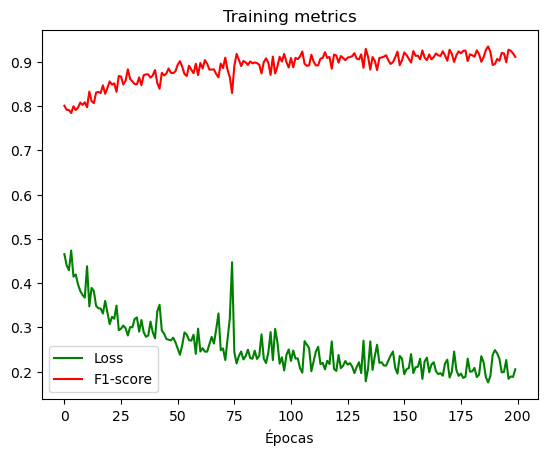

In [90]:
# Plot mean loss
x_axis = [i for i in range(200)]

splits=49
plt.plot(x_axis, [sum(mean_losses[i:i + splits])/splits for i in range(0, len(mean_losses), splits)], 'g', label='Loss')
# plt.plot(x_axis, [sum(mean_acc[i:i + splits])/splits for i in range(0, len(mean_acc), splits)], 'b', label='n')
plt.plot(x_axis, [sum(mean_f1s[i:i + splits])/splits for i in range(0, len(mean_f1s), splits)], 'r', label='F1-score')
plt.title('Training metrics')
plt.xlabel('Épocas')
# plt.ylabel('Loss media')
plt.legend()
plt.show()

In [91]:
trainer.save_checkpoint("saves/resnet50_PlantVillage_focalloss_transfer.pt")

Now we can reload it w/o training:

In [92]:
def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

inference_model = ResNetCustom.load_from_checkpoint("saves/resnet50_PlantVillage_focalloss_transfer.pt", map_location="cuda", gamma=0., class_sizes=[1,1])

In [93]:
from tqdm.autonotebook import tqdm

true_y, pred_y = [], []
for batch in tqdm(iter(dataloaders['val']), total=len(dataloaders['val'])):
    x, y = batch
    true_y.extend(y)
    preds, probs = get_prediction(x, inference_model)
    pred_y.extend(preds.cpu())

  0%|          | 0/13 [00:00<?, ?it/s]

In [94]:
from sklearn.metrics import classification_report
print(classification_report(true_y, pred_y, digits=3))

              precision    recall  f1-score   support

           0      0.978     0.972     0.975       326
           1      0.892     0.914     0.902        81

    accuracy                          0.961       407
   macro avg      0.935     0.943     0.939       407
weighted avg      0.961     0.961     0.961       407



## ResNet50 + transfer learning + 5-Fold

## <span style="color:blue">Plant Village</span>

In [5]:
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dataset = datasets.ImageFolder('../data/PlantVillage/train',data_transforms)

# Provocar bias cogiendo un porcentaje de la clase 1 solamente (modificando el porcentaje hasta obtener b_deg deseado)
class_0_idxs = torch.nonzero(torch.Tensor(image_dataset.targets)==0).flatten()
class_1_idxs = torch.nonzero(torch.Tensor(image_dataset.targets)==1).flatten()
# class_1_idxs = class_1_idxs[torch.randperm(len(class_1_idxs))[:int(len(class_1_idxs)*.209)]]

c0_s, c1_s = len(class_0_idxs), len(class_1_idxs)
b_deg = c0_s / c1_s
print('Class 0:', len(class_0_idxs), '/ Class 1:', len(class_1_idxs), '/ BDeg: ', b_deg)

class_1_subset = Subset(image_dataset, class_1_idxs)
class_0_subset = Subset(image_dataset, class_0_idxs)
image_dataset = ConcatDataset([class_0_subset, class_1_subset])

Class 0: 1591 / Class 1: 373 / BDeg:  4.265415549597855


In [8]:
from torchvision.models import resnet50

mean_losses = []
mean_acc = []
mean_f1s = []

class ResNetCustom(pl.LightningModule):
    def __init__(self, config, class_sizes):
        super().__init__()
        self.gamma = config['gamma']
        self.class_sizes = class_sizes
        self.lr = config['lr']
        self.n_classes = len(self.class_sizes)
        
        # metrics
        task = "multiclass" if self.n_classes > 2 else "binary"
        self.accuracy = torchmetrics.Accuracy(task=task, num_classes=self.n_classes)
        self.f1score = torchmetrics.F1Score(task=task, num_classes=self.n_classes)
        
        self.model = resnet50(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, self.n_classes, bias=True)
            
        self.fuzzyloss = FuzzyLoss(gamma=self.gamma, class_sizes=self.class_sizes).cuda()
#         self.fuzzyloss = nn.CrossEntropyLoss().cuda()
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_no):
        x, y = batch
        logits = self(x)
        
        y_onehot = F.one_hot(y, num_classes=self.n_classes).long()
        acc = self.accuracy(logits, y_onehot)
        f1s = self.f1score(logits, y_onehot)
        mean_acc.append(acc.item())
        mean_f1s.append(f1s.item())
        
        mean_loss, losses = self.fuzzyloss(logits, y)
#         mean_loss = self.fuzzyloss(logits, y)
        mean_losses.append(mean_loss)
        
        # Update focal loss with Fuzzy Control System
        self.fuzzyloss.update_hyperparams(losses, y)
        return mean_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=self.lr)
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.OneCycleLR(
                                optimizer ,max_lr=0.01,
                                steps_per_epoch=self.SPE,
                                epochs=self.EPOCHS)
        }

In [9]:
K=5
BATCH_SIZE=10
EPOCHS=1
GAMMA_0=2

def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

def train_tune(config):
    kfold = KFold(n_splits=K, shuffle=True)
    reports = []
    mean_f1s = []
    for fold,(train_idx,val_idx) in enumerate(kfold.split(image_dataset)):
        print(f'------------fold nº {fold}----------------------')

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
        trainloader = torch.utils.data.DataLoader(
                          image_dataset, 
                          batch_size=BATCH_SIZE, sampler=train_subsampler)
        testloader = torch.utils.data.DataLoader(
                          image_dataset,
                          batch_size=BATCH_SIZE, sampler=val_subsampler)

        # Train this fold
#         model = ResNetCustom(gamma=GAMMA_0, class_sizes=[c0_s,c1_s])
        model = ResNetCustom(config, class_sizes=[c0_s,c1_s])
        model.SPE = len(trainloader)
        model.EPOCHS = config['epochs']
        trainer = pl.Trainer(max_epochs=config['epochs'], devices=1, accelerator="gpu")
        trainer.fit(model, trainloader)

        # Test this fold
        true_y, pred_y = [], []
        for batch in tqdm(iter(testloader), total=len(testloader)):
            x, y = batch
            true_y.extend(y)
            preds, probs = get_prediction(x, model)
            pred_y.extend(preds.cpu())

        report = classification_report(true_y, pred_y, output_dict=True)
        reports.append(report)
        mean_f1s.append((report['0']['f1-score']+report['1']['f1-score'])/2)
#         print('=> CONFIG:', config)
#         print(classification_report(true_y, pred_y))
    max_f1_idx = mean_f1s.index(max(mean_f1s))
    return reports[max_f1_idx]

EPOCHS = [10, 25, 35]
GAMMAS = [0, 0.5, 2, 3]
LRS = [1e-4]

grid_search = pd.DataFrame(columns=['epochs','gamma','lr','f1-0','f1-1','acc'])

for epochs in EPOCHS:
    for gamma in GAMMAS:
        for lr in LRS:
            config = {'epochs': epochs, 'gamma': gamma, 'lr': lr}
            report = train_tune(config)
            grid_search = grid_search.append(
                            pd.Series(
                                [epochs,gamma,lr,report['0']['f1-score'],report['1']['f1-score'],report['accuracy']],
                                index=grid_search.columns), 
                            ignore_index=True)
            grid_search.to_csv('./grid_search/plant_village_fuzzyfocalloss.csv')
grid_search

------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.89it/s, loss=0.0592, v_num=172]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.0592, v_num=172]



100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.87it/s, loss=0.284, v_num=173] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.284, v_num=173]



100%|██████████| 40/40 [00:43<00:00,  1.09s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.87it/s, loss=0.0312, v_num=174]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.0312, v_num=174]



100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.87it/s, loss=0.0432, v_num=175]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.0432, v_num=175]



100%|██████████| 40/40 [00:44<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.0369, v_num=176]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.0369, v_num=176]



100%|██████████| 40/40 [00:43<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.87it/s, loss=0.281, v_num=177] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.281, v_num=177]



100%|██████████| 40/40 [00:43<00:00,  1.09s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.88it/s, loss=0.0784, v_num=178]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.0784, v_num=178]



100%|██████████| 40/40 [00:43<00:00,  1.08s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.0579, v_num=179]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.0579, v_num=179]



100%|██████████| 40/40 [00:43<00:00,  1.09s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.87it/s, loss=0.0407, v_num=180]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.0407, v_num=180]



100%|██████████| 40/40 [00:44<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.108, v_num=181] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.108, v_num=181]



100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.0637, v_num=182]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.0637, v_num=182]



100%|██████████| 40/40 [00:43<00:00,  1.08s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.87it/s, loss=0.0735, v_num=183]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.0735, v_num=183]



100%|██████████| 40/40 [00:43<00:00,  1.09s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.23, v_num=184]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.23, v_num=184]



100%|██████████| 40/40 [00:43<00:00,  1.08s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.87it/s, loss=0.071, v_num=185] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.071, v_num=185]



100%|██████████| 40/40 [00:43<00:00,  1.08s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.0528, v_num=186]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.0528, v_num=186]



100%|██████████| 40/40 [00:43<00:00,  1.09s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.0479, v_num=187]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.0479, v_num=187]



100%|██████████| 40/40 [00:44<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.0436, v_num=188]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.0436, v_num=188]



100%|██████████| 40/40 [00:43<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.0496, v_num=189]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.0496, v_num=189]



100%|██████████| 40/40 [00:44<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.87it/s, loss=0.0372, v_num=190]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.0372, v_num=190]



100%|██████████| 40/40 [00:43<00:00,  1.08s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.0835, v_num=191]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.0835, v_num=191]



100%|██████████| 40/40 [00:43<00:00,  1.09s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.87it/s, loss=0.012, v_num=192] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.012, v_num=192]



100%|██████████| 40/40 [00:44<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.0126, v_num=193]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.0126, v_num=193]



100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.0361, v_num=194] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.82it/s, loss=0.0361, v_num=194]



100%|██████████| 40/40 [00:44<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.0262, v_num=195] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.82it/s, loss=0.0262, v_num=195]



100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.0498, v_num=196]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.82it/s, loss=0.0498, v_num=196]



100%|██████████| 40/40 [00:43<00:00,  1.09s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.24, v_num=197]  

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.82it/s, loss=0.24, v_num=197]



100%|██████████| 40/40 [00:44<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.262, v_num=198] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.82it/s, loss=0.262, v_num=198]



100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.0741, v_num=199]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.82it/s, loss=0.0741, v_num=199]



100%|██████████| 40/40 [00:43<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.299, v_num=200] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.81it/s, loss=0.299, v_num=200]



100%|██████████| 40/40 [00:44<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.0356, v_num=201]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.80it/s, loss=0.0356, v_num=201]



100%|██████████| 40/40 [00:43<00:00,  1.09s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.0222, v_num=202]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.80it/s, loss=0.0222, v_num=202]



100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.82it/s, loss=0.258, v_num=203] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.80it/s, loss=0.258, v_num=203]



100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.82it/s, loss=0.204, v_num=204]  

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.79it/s, loss=0.204, v_num=204]



100%|██████████| 40/40 [00:44<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.82it/s, loss=0.0329, v_num=205] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.79it/s, loss=0.0329, v_num=205]



100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.81it/s, loss=0.0961, v_num=206] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.78it/s, loss=0.0961, v_num=206]



100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.81it/s, loss=0.0581, v_num=207] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.78it/s, loss=0.0581, v_num=207]



100%|██████████| 40/40 [00:46<00:00,  1.15s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.80it/s, loss=0.0803, v_num=208]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.78it/s, loss=0.0803, v_num=208]



100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.79it/s, loss=0.103, v_num=209] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:57<00:00,  2.76it/s, loss=0.103, v_num=209]



100%|██████████| 40/40 [00:44<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.79it/s, loss=0.0179, v_num=210] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:57<00:00,  2.77it/s, loss=0.0179, v_num=210]



100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.79it/s, loss=0.022, v_num=211] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:57<00:00,  2.76it/s, loss=0.022, v_num=211]



100%|██████████| 40/40 [00:44<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 34: 100%|██████████| 158/158 [00:56<00:00,  2.77it/s, loss=0.0604, v_num=212]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:57<00:00,  2.75it/s, loss=0.0604, v_num=212]



100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 34: 100%|██████████| 158/158 [00:57<00:00,  2.76it/s, loss=0.296, v_num=213] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:57<00:00,  2.74it/s, loss=0.296, v_num=213]



100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 34: 100%|██████████| 158/158 [00:57<00:00,  2.75it/s, loss=0.0821, v_num=214] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:57<00:00,  2.73it/s, loss=0.0821, v_num=214]



100%|██████████| 40/40 [00:45<00:00,  1.15s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 34: 100%|██████████| 158/158 [00:57<00:00,  2.75it/s, loss=0.0488, v_num=215] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:58<00:00,  2.72it/s, loss=0.0488, v_num=215]



100%|██████████| 40/40 [00:45<00:00,  1.15s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 34: 100%|██████████| 158/158 [00:57<00:00,  2.73it/s, loss=0.0374, v_num=216] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:58<00:00,  2.71it/s, loss=0.0374, v_num=216]



100%|██████████| 40/40 [00:45<00:00,  1.15s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 34: 100%|██████████| 158/158 [00:58<00:00,  2.71it/s, loss=0.0226, v_num=217]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:58<00:00,  2.68it/s, loss=0.0226, v_num=217]



100%|██████████| 40/40 [00:46<00:00,  1.15s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 34: 100%|██████████| 158/158 [00:58<00:00,  2.70it/s, loss=0.279, v_num=218] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:59<00:00,  2.67it/s, loss=0.279, v_num=218]



100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 34: 100%|██████████| 158/158 [00:59<00:00,  2.66it/s, loss=0.0324, v_num=219] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:59<00:00,  2.63it/s, loss=0.0324, v_num=219]



100%|██████████| 40/40 [00:46<00:00,  1.17s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 34: 100%|██████████| 158/158 [00:59<00:00,  2.66it/s, loss=0.0302, v_num=220] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:59<00:00,  2.64it/s, loss=0.0302, v_num=220]



100%|██████████| 40/40 [00:46<00:00,  1.15s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 34: 100%|██████████| 158/158 [01:00<00:00,  2.62it/s, loss=0.0459, v_num=221] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:00<00:00,  2.60it/s, loss=0.0459, v_num=221]



100%|██████████| 40/40 [00:47<00:00,  1.19s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 34: 100%|██████████| 158/158 [01:01<00:00,  2.57it/s, loss=0.188, v_num=222]  

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:01<00:00,  2.55it/s, loss=0.188, v_num=222]



100%|██████████| 40/40 [00:47<00:00,  1.19s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 34: 100%|██████████| 158/158 [01:01<00:00,  2.56it/s, loss=0.0275, v_num=223]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:02<00:00,  2.54it/s, loss=0.0275, v_num=223]



100%|██████████| 40/40 [00:48<00:00,  1.22s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 34: 100%|██████████| 158/158 [01:01<00:00,  2.55it/s, loss=0.229, v_num=224]  

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:02<00:00,  2.53it/s, loss=0.229, v_num=224]



100%|██████████| 40/40 [00:47<00:00,  1.19s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 34: 100%|██████████| 158/158 [01:03<00:00,  2.48it/s, loss=0.0155, v_num=225] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:04<00:00,  2.46it/s, loss=0.0155, v_num=225]



100%|██████████| 40/40 [00:48<00:00,  1.20s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 34: 100%|██████████| 158/158 [01:04<00:00,  2.45it/s, loss=0.0313, v_num=226] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:04<00:00,  2.43it/s, loss=0.0313, v_num=226]



100%|██████████| 40/40 [00:48<00:00,  1.22s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 34: 100%|██████████| 158/158 [01:05<00:00,  2.43it/s, loss=0.0372, v_num=227] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:05<00:00,  2.41it/s, loss=0.0372, v_num=227]



100%|██████████| 40/40 [00:49<00:00,  1.24s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 34: 100%|██████████| 158/158 [01:05<00:00,  2.42it/s, loss=0.0353, v_num=228] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:05<00:00,  2.40it/s, loss=0.0353, v_num=228]



100%|██████████| 40/40 [00:48<00:00,  1.22s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 34: 100%|██████████| 158/158 [01:06<00:00,  2.38it/s, loss=0.0612, v_num=229] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:07<00:00,  2.36it/s, loss=0.0612, v_num=229]



100%|██████████| 40/40 [00:49<00:00,  1.23s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 34: 100%|██████████| 158/158 [01:07<00:00,  2.35it/s, loss=0.0416, v_num=230]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:07<00:00,  2.33it/s, loss=0.0416, v_num=230]



100%|██████████| 40/40 [00:50<00:00,  1.26s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 34: 100%|██████████| 158/158 [01:08<00:00,  2.31it/s, loss=0.0642, v_num=231] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:08<00:00,  2.29it/s, loss=0.0642, v_num=231]



100%|██████████| 40/40 [00:49<00:00,  1.23s/it]


,epochs,gamma,lr,f1-0,f1-1,acc
0,10.0,0.0,0.0001,0.998473,0.992366,0.997455
1,10.0,0.5,0.0001,0.998410,0.993631,0.997455
2,10.0,2.0,0.0001,0.998483,0.992126,0.997455
3,10.0,3.0,0.0001,0.998445,0.993007,0.997455
4,25.0,0.0,0.0001,1.000000,1.000000,1.000000
5,25.0,0.5,0.0001,1.000000,1.000000,1.000000
6,25.0,2.0,0.0001,0.998415,0.993548,0.997455
7,25.0,3.0,0.0001,1.000000,1.000000,1.000000
8,35.0,0.0,0.0001,0.998420,0.993464,0.997455
9,35.0,0.5,0.0001,1.000000,1.000000,1.000000


In [10]:
mean_losses = []
mean_acc = []
mean_f1s = []

config = {'epochs': 25, 'gamma': 2, 'lr': 1e-3}
report = train_tune(config)
print(report)

------------fold nº 0----------------------


C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
-------------------

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.00995, v_num=232]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.82it/s, loss=0.00995, v_num=232]



100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.0259, v_num=233] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.0259, v_num=233]



100%|██████████| 40/40 [00:43<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.0155, v_num=234]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.0155, v_num=234]



100%|██████████| 40/40 [00:43<00:00,  1.09s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.027, v_num=235]  

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.027, v_num=235]



100%|██████████| 40/40 [00:44<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0     
2 | model     | ResNet         | 23.5 M
3 | fuzzyloss | FuzzyLoss      | 0     
---------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfo

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.0271, v_num=236] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.0271, v_num=236]



100%|██████████| 40/40 [00:43<00:00,  1.10s/it]

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 311}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 82}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 393}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 393}}


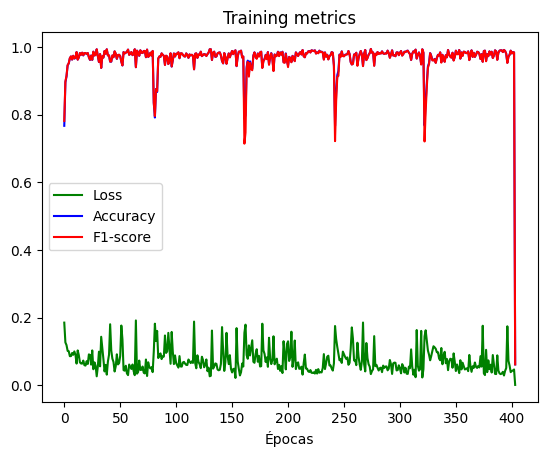

In [15]:
# Plot mean loss
splits = 49
ml = [sum(mean_losses[i:i + splits])/splits for i in range(0, len(mean_losses), splits)]
ma = [sum(mean_acc[i:i + splits])/splits for i in range(0, len(mean_acc), splits)]
mf = [sum(mean_f1s[i:i + splits])/splits for i in range(0, len(mean_f1s), splits)]
x_axis = [i for i in range(404)]

for i, l in enumerate(mean_losses):
    mean_losses[i] = l.cpu().detach()
plt.plot(x_axis, ml, 'g', label='Loss')
plt.plot(x_axis, ma, 'b', label='Accuracy')
plt.plot(x_axis, mf, 'r', label='F1-score')
plt.title('Training metrics')
plt.xlabel('Épocas')
# plt.ylabel('Loss media')
plt.legend()
plt.show()

## <span style="color:blue">UTKFace</span>

In [50]:
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dataset = datasets.ImageFolder('../data/UTKFace/train',data_transforms)

# Provocar bias cogiendo un porcentaje de la clase 1 solamente (modificando el porcentaje hasta obtener b_deg deseado)
class_0_idxs = torch.nonzero(torch.Tensor(image_dataset.targets)==0).flatten()
class_1_idxs = torch.nonzero(torch.Tensor(image_dataset.targets)==1).flatten()
class_1_idxs = class_1_idxs[torch.randperm(len(class_1_idxs))[:int(len(class_1_idxs)*.209)]]

c0_s, c1_s = len(class_0_idxs), len(class_1_idxs)
b_deg = c0_s / c1_s
print('Class 0:', len(class_0_idxs), '/ Class 1:', len(class_1_idxs), '/ BDeg: ', b_deg)

class_1_subset = Subset(image_dataset, class_1_idxs)
class_0_subset = Subset(image_dataset, class_0_idxs)
image_dataset = ConcatDataset([class_0_subset, class_1_subset])

Class 0: 11317 / Class 1: 2589 / BDeg:  4.371185786017768


In [53]:
from torchvision.models import resnet50

mean_losses = []
mean_acc = []
mean_f1s = []

class ResNetCustom(pl.LightningModule):
    def __init__(self,
                 gamma=0.,
                 class_sizes=[1,1],
        ):
        super().__init__()
        self.gamma = config['gamma']
        self.class_sizes = class_sizes
        self.lr = config['lr']
        self.n_classes = len(self.class_sizes)
        
        # metrics
        task = "multiclass" if self.n_classes > 2 else "binary"
        self.accuracy = torchmetrics.Accuracy(task=task, num_classes=self.n_classes)
        self.f1score = torchmetrics.F1Score(task=task, num_classes=self.n_classes)
        
        self.model = resnet50(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, self.n_classes, bias=True)
            
        self.fuzzyloss = FuzzyLoss(gamma=gamma, class_sizes=self.class_sizes).cuda()
#         self.fuzzyloss = nn.CrossEntropyLoss().cuda()
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_no):
        x, y = batch
        logits = self(x)
        
        y_onehot = F.one_hot(y, num_classes=self.n_classes).long()
        acc = self.accuracy(logits, y_onehot)
        f1s = self.f1score(logits, y_onehot)
        mean_acc.append(acc.item())
        mean_f1s.append(f1s.item())
        
        mean_loss, losses = self.fuzzyloss(logits, y)
#         mean_loss = self.fuzzyloss(logits, y)
        mean_losses.append(mean_loss)
        
        # Update focal loss with Fuzzy Control System
        self.fuzzyloss.update_hyperparams(losses, y)
        return mean_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=1e-4)
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.OneCycleLR(
                                optimizer ,max_lr=0.01,
                                steps_per_epoch=self.SPE,
                                epochs=self.EPOCHS)
        }

In [54]:
K=5
BATCH_SIZE=10
EPOCHS=1
GAMMA_0=2

def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

def train_tune(config):
    kfold = KFold(n_splits=K, shuffle=True)
    reports = []
    mean_f1s = []
    for fold,(train_idx,val_idx) in enumerate(kfold.split(image_dataset)):
        print(f'------------fold nº {fold}----------------------')

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
        trainloader = torch.utils.data.DataLoader(
                          image_dataset, 
                          batch_size=BATCH_SIZE, sampler=train_subsampler)
        testloader = torch.utils.data.DataLoader(
                          image_dataset,
                          batch_size=BATCH_SIZE, sampler=val_subsampler)

        # Train this fold
#         model = ResNetCustom(gamma=GAMMA_0, class_sizes=[c0_s,c1_s])
        model = ResNetCustom(config, class_sizes=[c0_s,c1_s])
        model.SPE = len(trainloader)
        model.EPOCHS = config['epochs']
        trainer = pl.Trainer(max_epochs=config['epochs'], devices=1, accelerator="gpu")
        trainer.fit(model, trainloader)

        # Test this fold
        true_y, pred_y = [], []
        for batch in tqdm(iter(testloader), total=len(testloader)):
            x, y = batch
            true_y.extend(y)
            preds, probs = get_prediction(x, model)
            pred_y.extend(preds.cpu())

        report = classification_report(true_y, pred_y, output_dict=True)
        reports.append(report)
        mean_f1s.append((report['0']['f1-score']+report['1']['f1-score'])/2)
#         print('=> CONFIG:', config)
#         print(classification_report(true_y, pred_y))
    max_f1_idx = mean_f1s.index(max(mean_f1s))
    return reports[max_f1_idx]

EPOCHS = [10, 25, 35]
GAMMAS = [0]
LRS = [1e-3]

grid_search = pd.DataFrame(columns=['epochs','gamma','lr','f1-0','f1-1','acc'])

for epochs in EPOCHS:
    for gamma in GAMMAS:
        for lr in LRS:
            config = {'epochs': epochs, 'gamma': gamma, 'lr': lr}
            report = train_tune(config)
            grid_search = grid_search.append(
                            pd.Series(
                                [epochs,gamma,lr,report['0']['f1-score'],report['1']['f1-score'],report['accuracy']],
                                index=grid_search.columns), 
                            ignore_index=True)
            grid_search.to_csv('./grid_search/UTKFace_baseline.csv')
grid_search

------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 1113/1113 [06:42<00:00,  2.76it/s, loss=0.373, v_num=151]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1113/1113 [06:43<00:00,  2.76it/s, loss=0.373, v_num=151]


100%|██████████| 279/279 [05:19<00:00,  1.15s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 1113/1113 [06:41<00:00,  2.77it/s, loss=0.366, v_num=152]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1113/1113 [06:41<00:00,  2.77it/s, loss=0.366, v_num=152]


100%|██████████| 279/279 [05:21<00:00,  1.15s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 1113/1113 [06:40<00:00,  2.78it/s, loss=0.396, v_num=153]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1113/1113 [06:40<00:00,  2.78it/s, loss=0.396, v_num=153]


100%|██████████| 279/279 [05:17<00:00,  1.14s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 1113/1113 [06:39<00:00,  2.78it/s, loss=0.453, v_num=154]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1113/1113 [06:40<00:00,  2.78it/s, loss=0.453, v_num=154]


100%|██████████| 279/279 [05:18<00:00,  1.14s/it]


------------fold nº 4----------------------


C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------

Epoch 9: 100%|██████████| 1113/1113 [06:40<00:00,  2.78it/s, loss=0.316, v_num=155]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1113/1113 [06:40<00:00,  2.78it/s, loss=0.316, v_num=155]


100%|██████████| 279/279 [05:08<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 1113/1113 [06:41<00:00,  2.77it/s, loss=0.405, v_num=156]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1113/1113 [06:41<00:00,  2.77it/s, loss=0.405, v_num=156]


100%|██████████| 279/279 [05:16<00:00,  1.14s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 1113/1113 [06:44<00:00,  2.75it/s, loss=0.409, v_num=157]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1113/1113 [06:44<00:00,  2.75it/s, loss=0.409, v_num=157]


100%|██████████| 279/279 [05:20<00:00,  1.15s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 1113/1113 [06:45<00:00,  2.75it/s, loss=0.395, v_num=158]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1113/1113 [06:45<00:00,  2.74it/s, loss=0.395, v_num=158]


100%|██████████| 279/279 [05:23<00:00,  1.16s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 1113/1113 [06:49<00:00,  2.72it/s, loss=0.481, v_num=159]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1113/1113 [06:49<00:00,  2.72it/s, loss=0.481, v_num=159]


100%|██████████| 279/279 [05:26<00:00,  1.17s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 1113/1113 [06:51<00:00,  2.71it/s, loss=0.365, v_num=160]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1113/1113 [06:51<00:00,  2.70it/s, loss=0.365, v_num=160]


100%|██████████| 279/279 [05:25<00:00,  1.17s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 1113/1113 [06:56<00:00,  2.67it/s, loss=0.352, v_num=161]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 1113/1113 [06:57<00:00,  2.67it/s, loss=0.352, v_num=161]


100%|██████████| 279/279 [05:30<00:00,  1.19s/it]


------------fold nº 1----------------------


C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------

Epoch 34: 100%|██████████| 1113/1113 [07:06<00:00,  2.61it/s, loss=0.471, v_num=162]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 1113/1113 [07:06<00:00,  2.61it/s, loss=0.471, v_num=162]


100%|██████████| 279/279 [05:35<00:00,  1.20s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 1113/1113 [07:19<00:00,  2.53it/s, loss=0.403, v_num=163]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 1113/1113 [07:20<00:00,  2.53it/s, loss=0.403, v_num=163]


100%|██████████| 279/279 [05:38<00:00,  1.21s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 1113/1113 [07:33<00:00,  2.45it/s, loss=0.326, v_num=164]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 1113/1113 [07:34<00:00,  2.45it/s, loss=0.326, v_num=164]


100%|██████████| 279/279 [05:38<00:00,  1.21s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 1113/1113 [07:34<00:00,  2.45it/s, loss=0.392, v_num=165]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 1113/1113 [07:35<00:00,  2.44it/s, loss=0.392, v_num=165]


100%|██████████| 279/279 [05:45<00:00,  1.24s/it]


,epochs,gamma,lr,f1-0,f1-1,acc
0,10.0,0.0,0.001,0.905232,0.438356,0.837828
1,25.0,0.0,0.001,0.884323,0.522140,0.813736
2,35.0,0.0,0.001,0.894760,0.509165,0.826681


In [55]:
mean_losses = []
mean_acc = []
mean_f1s = []

config = {'epochs': 25, 'gamma': 0, 'lr': 1e-3}
report = train_tune(config)
print(report)

------------fold nº 0----------------------


C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------

Epoch 24: 100%|██████████| 1113/1113 [06:40<00:00,  2.78it/s, loss=0.365, v_num=166]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1113/1113 [06:40<00:00,  2.78it/s, loss=0.365, v_num=166]


100%|██████████| 279/279 [05:12<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 1113/1113 [06:40<00:00,  2.78it/s, loss=0.362, v_num=167]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1113/1113 [06:40<00:00,  2.78it/s, loss=0.362, v_num=167]


100%|██████████| 279/279 [05:11<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 1113/1113 [06:41<00:00,  2.77it/s, loss=0.305, v_num=168]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1113/1113 [06:42<00:00,  2.77it/s, loss=0.305, v_num=168]


100%|██████████| 279/279 [05:12<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 1113/1113 [06:42<00:00,  2.76it/s, loss=0.342, v_num=169]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1113/1113 [06:43<00:00,  2.76it/s, loss=0.342, v_num=169]


100%|██████████| 279/279 [05:10<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 1113/1113 [06:45<00:00,  2.75it/s, loss=0.419, v_num=170]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1113/1113 [06:45<00:00,  2.74it/s, loss=0.419, v_num=170]


100%|██████████| 279/279 [05:15<00:00,  1.13s/it]


{'0': {'precision': 0.8777643747486932, 'recall': 0.9566170026292725, 'f1-score': 0.9154959110924721, 'support': 2282}, '1': {'precision': 0.6632653061224489, 'recall': 0.3907815631262525, 'f1-score': 0.4918032786885246, 'support': 499}, 'accuracy': 0.8550880978065444, 'macro avg': {'precision': 0.7705148404355711, 'recall': 0.6736992828777625, 'f1-score': 0.7036495948904984, 'support': 2781}, 'weighted avg': {'precision': 0.8392764081019849, 'recall': 0.8550880978065444, 'f1-score': 0.8394719543971935, 'support': 2781}}


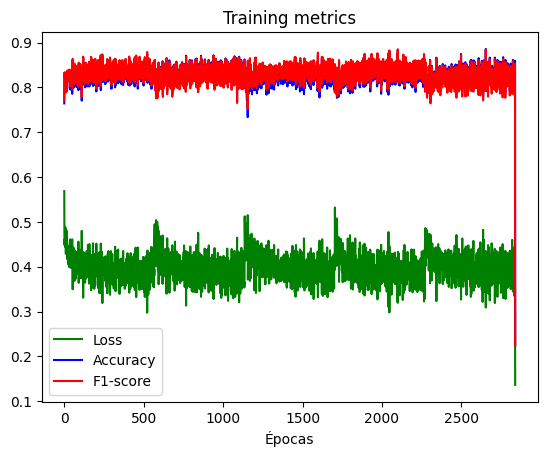

In [58]:
# Plot mean loss
ml = [sum(mean_losses[i:i + splits])/splits for i in range(0, len(mean_losses), splits)]
ma = [sum(mean_acc[i:i + splits])/splits for i in range(0, len(mean_acc), splits)]
mf = [sum(mean_f1s[i:i + splits])/splits for i in range(0, len(mean_f1s), splits)]
x_axis = [i for i in range(2840)]

splits=49
for i, l in enumerate(mean_losses):
    mean_losses[i] = l.cpu().detach()
plt.plot(x_axis, ml, 'g', label='Loss')
plt.plot(x_axis, ma, 'b', label='Accuracy')
plt.plot(x_axis, mf, 'r', label='F1-score')
plt.title('Training metrics')
plt.xlabel('Épocas')
# plt.ylabel('Loss media')
plt.legend()
plt.show()

## <span style="color:blue">gender_clf</span>

In [3]:
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dataset = datasets.ImageFolder('../data/gender_clf/train',data_transforms)

# Provocar bias cogiendo un porcentaje de la clase 1 solamente (modificando el porcentaje hasta obtener b_deg deseado)
class_0_idxs = torch.nonzero(torch.Tensor(image_dataset.targets)==0).flatten()
class_1_idxs = torch.nonzero(torch.Tensor(image_dataset.targets)==1).flatten()
class_1_idxs = class_1_idxs[torch.randperm(len(class_1_idxs))[:int(len(class_1_idxs)*.209)]]

c0_s, c1_s = len(class_0_idxs), len(class_1_idxs)
b_deg = c0_s / c1_s
print('Class 0:', len(class_0_idxs), '/ Class 1:', len(class_1_idxs), '/ BDeg: ', b_deg)

class_1_subset = Subset(image_dataset, class_1_idxs)
class_0_subset = Subset(image_dataset, class_0_idxs)
image_dataset = ConcatDataset([class_0_subset, class_1_subset])

Class 0: 23243 / Class 1: 4967 / BDeg:  4.679484598349104


In [4]:
from torchvision.models import resnet50

mean_losses = []
mean_acc = []
mean_f1s = []

class ResNetCustom(pl.LightningModule):
    def __init__(self,
                 gamma=0.,
                 class_sizes=[1,1],
        ):
        super().__init__()
        self.n_classes = len(class_sizes)
        
        # metrics
        task = "multiclass" if self.n_classes > 2 else "binary"
        self.accuracy = torchmetrics.Accuracy(task=task, num_classes=self.n_classes)
        self.f1score = torchmetrics.F1Score(task=task, num_classes=self.n_classes)
        
        self.model = resnet50(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, self.n_classes, bias=True)
            
#         self.fuzzyloss = FuzzyLoss(gamma=gamma, class_sizes=class_sizes).cuda()
        self.fuzzyloss = nn.CrossEntropyLoss().cuda()
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_no):
        x, y = batch
        logits = self(x)
        
        y_onehot = F.one_hot(y, num_classes=self.n_classes).long()
        acc = self.accuracy(logits, y_onehot)
        f1s = self.f1score(logits, y_onehot)
        mean_acc.append(acc.item())
        mean_f1s.append(f1s.item())
        
#         mean_loss, losses = self.fuzzyloss(logits, y)
        mean_loss = self.fuzzyloss(logits, y)
        mean_losses.append(mean_loss)
        
        # Update focal loss with Fuzzy Control System
#         self.fuzzyloss.update_hyperparams(losses, y)
        return mean_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=1e-4)
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.OneCycleLR(
                                optimizer ,max_lr=0.01,
                                steps_per_epoch=len(trainloader),
                                epochs=EPOCHS)
        }

In [5]:
EPOCHS=25
K=5
GAMMA_0=2
BATCH_SIZE=10

def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

kfold = KFold(n_splits=K, shuffle=True)
for fold,(train_idx,val_idx) in enumerate(kfold.split(image_dataset)):
    print(f'------------fold nº {fold}----------------------')
    
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    trainloader = torch.utils.data.DataLoader(
                      image_dataset, 
                      batch_size=BATCH_SIZE, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      image_dataset,
                      batch_size=BATCH_SIZE, sampler=val_subsampler)
    
    # Train this fold
    model = ResNetCustom(gamma=GAMMA_0, class_sizes=[c0_s,c1_s])
    trainer = pl.Trainer(gpus=1, max_epochs=EPOCHS, devices=1, accelerator="gpu")
    trainer.fit(model, trainloader)
    
    # Test this fold
    true_y, pred_y = [], []
    for batch in tqdm(iter(testloader), total=len(testloader)):
        x, y = batch
        true_y.extend(y)
        preds, probs = get_prediction(x, model)
        pred_y.extend(preds.cpu())
    
    print(classification_report(true_y, pred_y, digits=3))

------------fold nº 0----------------------


/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Scor

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


  0%|          | 0/565 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      0.875     0.987     0.927      4615
           1      0.860     0.365     0.513      1027

    accuracy                          0.874      5642
   macro avg      0.867     0.676     0.720      5642
weighted avg      0.872     0.874     0.852      5642

------------fold nº 1----------------------


/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Scor

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


  0%|          | 0/565 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      0.902     0.971     0.935      4637
           1      0.794     0.513     0.624      1005

    accuracy                          0.890      5642
   macro avg      0.848     0.742     0.779      5642
weighted avg      0.883     0.890     0.880      5642

------------fold nº 2----------------------


/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Scor

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


  0%|          | 0/565 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      0.938     0.906     0.922      4650
           1      0.620     0.718     0.665       992

    accuracy                          0.873      5642
   macro avg      0.779     0.812     0.793      5642
weighted avg      0.882     0.873     0.876      5642

------------fold nº 3----------------------


/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Scor

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


  0%|          | 0/565 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      0.954     0.834     0.890      4678
           1      0.500     0.805     0.617       964

    accuracy                          0.829      5642
   macro avg      0.727     0.820     0.753      5642
weighted avg      0.876     0.829     0.843      5642

------------fold nº 4----------------------


/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Scor

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


  0%|          | 0/565 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      0.869     0.991     0.926      4663
           1      0.868     0.289     0.434       979

    accuracy                          0.869      5642
   macro avg      0.869     0.640     0.680      5642
weighted avg      0.869     0.869     0.841      5642



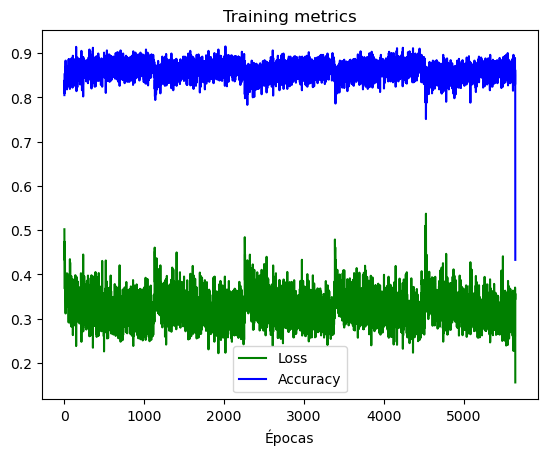

In [9]:
# Plot mean loss
x_axis = [i for i in range(5643)]

splits=50
plt.plot(x_axis, [sum(mean_losses[i:i + splits])/splits for i in range(0, len(mean_losses), splits)], 'g', label='Loss')
plt.plot(x_axis, [sum(mean_acc[i:i + splits])/splits for i in range(0, len(mean_acc), splits)], 'b', label='Accuracy')
# plt.plot(x_axis, [sum(mean_f1s[i:i + splits])/splits for i in range(0, len(mean_f1s), splits)], 'r', label='F1-score')
plt.title('Training metrics')
plt.xlabel('Épocas')
# plt.ylabel('Loss media')
plt.legend()
plt.show()